In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [32]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
# first check current device that tensor computations will run on (recommended GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device >>>>>>>>",device)

Device >>>>>>>> cuda:0


In [33]:
# initialize dataset object
img_size=32
batch_size=64
transform = transforms.Compose([
        transforms.Scale(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5), std=(0.5))
])
dataset = torchvision.datasets.MNIST(root='data/', train=True, transform=transform, download=True)
print(dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               Scale(size=32, interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [34]:
# invoke dataloader object to load and yield samples from the dataset
# Data loader. Combines a dataset and a sampler, and provides an iterable over the given dataset.
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)

label >>>> 3
label >>>> 1
label >>>> 9
label >>>> 8
label >>>> 0
label >>>> 2
label >>>> 8
label >>>> 7


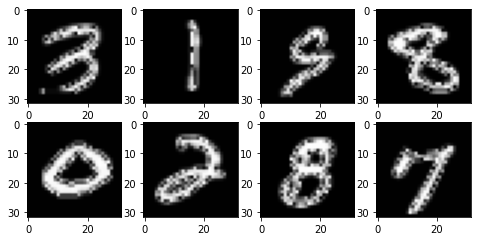

In [35]:
# plot samples of the dataset
fig=plt.figure(figsize=(8, 8))
rows=4
cols=4
ldr=iter(dataloader)
for i in range(1,9):
    img,label=next(ldr)
    fig.add_subplot(rows, cols, i)
    idx=np.random.randint(low=0,high=64,size=1)
    plt.imshow(transforms.ToPILImage()(torch.squeeze(img[idx])),cmap="gray") # transform tensor to PIL image
    print("label >>>>",label[idx].item())

In [36]:
# utils
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)    

In [37]:
class PreGeneratorHiddenLayers(nn.Module):
    """
    class implements the hidden layer before generation done
    """
    def __init__(self,dimin,dimout,kernel=4,stride=1):
        super().__init__()
        self.dimin=dimin
        self.dimout=dimout
        self.kernel=kernel
        self.stride=stride
        self.net=nn.Sequential(
            nn.ConvTranspose2d(self.dimin,self.dimout,self.kernel,self.stride),
            nn.BatchNorm2d(self.dimout),
            nn.ReLU(inplace=True)
        )
    
    def forward(self,input_noise_z):
        return self.net.forward(input_noise_z)

class PreDiscriminatorHiddenLayers(nn.Module):
    """
    class implements the hidden layer before generation done
    """
    def __init__(self,dimin=10,dimout=64,kernel=4,stride=2,padding=1):
        super().__init__()
        self.dimin=dimin
        self.dimout=dimout
        self.kernel=kernel
        self.stride=stride
        self.padding=padding
        self.net=nn.Sequential(
            nn.Conv2d(self.dimin,self.dimout,self.kernel,self.stride,self.padding),
            nn.LeakyReLU(inplace=True)
        )
    
    def forward(self,label):
        return self.net.forward(label)

In [38]:
# Generator network
class Generator(nn.Module):
    def __init__(self,input_filters=512,out_filters=256):
        self.input_filters=input_filters
        self.out_filters=out_filters
        super().__init__()
        self.net=nn.Sequential(
            # generator receives tensor with 512 filters each of 4*4
            nn.ConvTranspose2d(in_channels=self.input_filters,out_channels=self.out_filters,kernel_size=4,stride =2 , padding=1,bias=False),
            # out now is >>>> (256,8,8)
            nn.BatchNorm2d(self.out_filters),
            nn.LeakyReLU(0.2,inplace=True),
            # out now is >>>> (256,8,8) batch normed and activated with Relu
            nn.ConvTranspose2d(in_channels=self.out_filters, out_channels=self.out_filters//2, kernel_size=4, stride=2,padding=1,bias=False),
            nn.BatchNorm2d(self.out_filters//2),
            nn.LeakyReLU(0.2,inplace=True),
            # out now 128 x 16 x 16 batch normed and activated with Relu
            nn.ConvTranspose2d(in_channels=self.out_filters//2, out_channels=1 , kernel_size=4, stride=2,padding=1,bias=False),
            nn.Tanh()
            # out now 1 x 32 x 32 Tanh activated
        )
        
    def forward(self, input_tensor):
        return self.net.forward(input_tensor)

# Discriminator network
class Discriminator(nn.Module):
    def __init__(self,input_filters=128,out_filters=256):
        self.input_filters=input_filters
        self.out_filters=out_filters
        super().__init__()
        self.net = nn.Sequential(
            # input is (128) x 16 x 16
            nn.Conv2d(self.input_filters, self.out_filters, kernel_size=4, stride=2,padding=1,bias=False),
            nn.BatchNorm2d(self.out_filters),
            nn.LeakyReLU(0.2, inplace=True),
            # result now (256) x 8 x 8
            nn.Conv2d(self.out_filters, self.out_filters * 2, kernel_size=4, stride=2,padding=1,bias=False),
            nn.BatchNorm2d(self.out_filters * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # result now (512) x 4 x 4
            nn.Conv2d(self.out_filters * 2, 1, kernel_size=4, stride=1,padding=0,bias=False),
            nn.Sigmoid() # real or fake node
        )

    def forward(self, input_tensor):
        return self.net.forward(input_tensor)

In [39]:
netG=Generator().to(device)
netG.apply(weights_init)

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)

In [40]:
netD=Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (net): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (7): Sigmoid()
  )
)

In [41]:
predisc1=PreDiscriminatorHiddenLayers(dimin=10,dimout=64).to(device)
predisc1.apply(weights_init)
predisc2=PreDiscriminatorHiddenLayers(dimin=1,dimout=64).to(device)
predisc2.apply(weights_init)

PreDiscriminatorHiddenLayers(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
  )
)

In [42]:
pregen1=PreGeneratorHiddenLayers(dimin=100,dimout=256).to(device)
pregen1.apply(weights_init)
pregen2=PreGeneratorHiddenLayers(dimin=10,dimout=256).to(device)
pregen2.apply(weights_init)

PreGeneratorHiddenLayers(
  (net): Sequential(
    (0): ConvTranspose2d(10, 256, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
)

In [43]:
# Define loss and optimization
# Initialize BCELoss function
criterion = nn.BCELoss()

# Setup SGD optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002,betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002,betas=(0.5, 0.999))

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

Starting Training Loop >>>
cls >>>  0


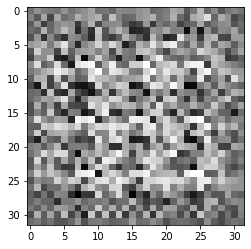

error D >>>  tensor(0.3677, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.1203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  4


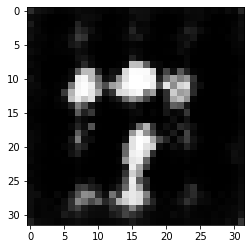

error D >>>  tensor(0.9252, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.0878, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  2


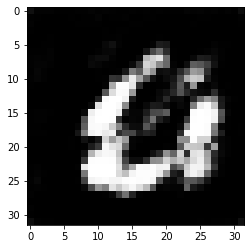

error D >>>  tensor(0.7875, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.3236, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  0


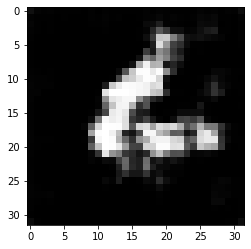

error D >>>  tensor(0.8977, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.2172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  5


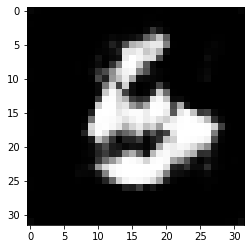

error D >>>  tensor(0.6463, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.3398, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


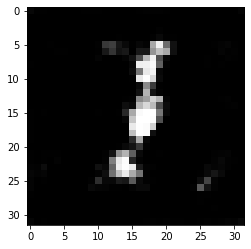

error D >>>  tensor(0.7382, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.1903, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  7


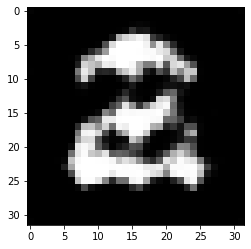

error D >>>  tensor(0.6054, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(1.7956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  9


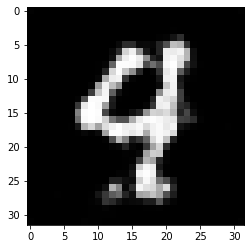

error D >>>  tensor(0.7150, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.3340, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  7


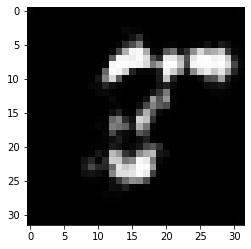

error D >>>  tensor(0.7631, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.0371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  0


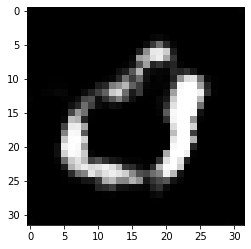

error D >>>  tensor(0.4499, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.5104, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  5


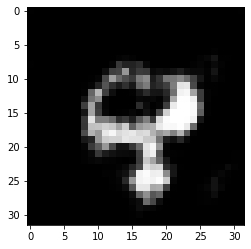

error D >>>  tensor(0.7487, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.7321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  2


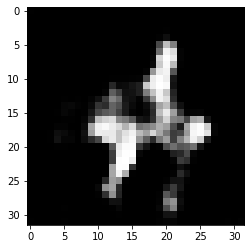

error D >>>  tensor(0.6256, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.6660, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


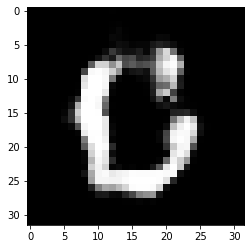

error D >>>  tensor(0.4716, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.6991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  5


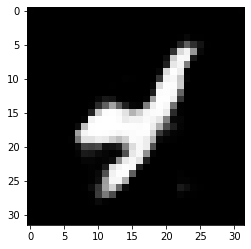

error D >>>  tensor(0.4323, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.7786, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  2


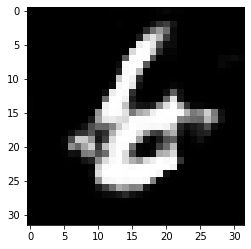

error D >>>  tensor(0.5189, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.5441, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  2


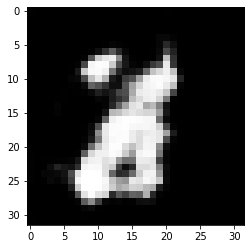

error D >>>  tensor(0.6978, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.8373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  4


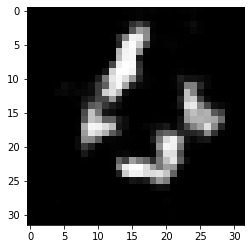

error D >>>  tensor(0.3840, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.5170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


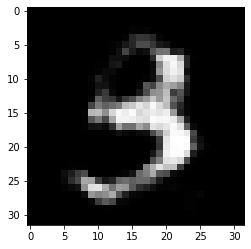

error D >>>  tensor(0.8807, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.2348, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  1


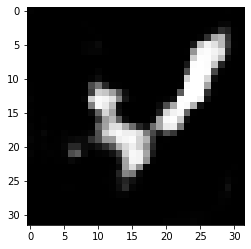

error D >>>  tensor(0.4507, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.3262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


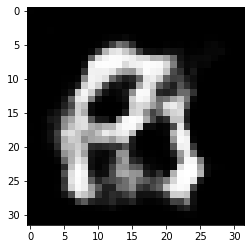

error D >>>  tensor(0.3756, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.7506, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  6


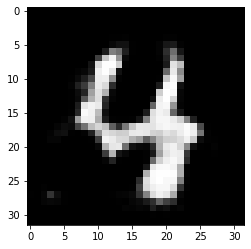

error D >>>  tensor(0.6760, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(1.8512, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  2


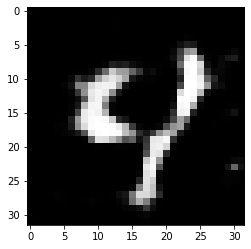

error D >>>  tensor(0.6772, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.0617, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  8


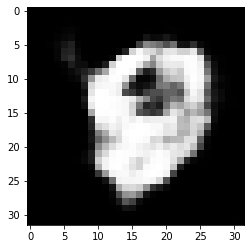

error D >>>  tensor(0.7850, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(1.2239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  5


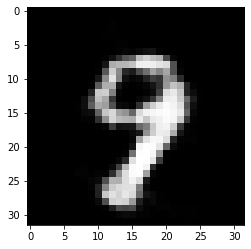

error D >>>  tensor(0.4223, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.2802, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


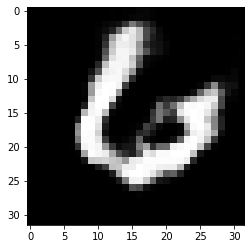

error D >>>  tensor(0.5370, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.9217, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  4


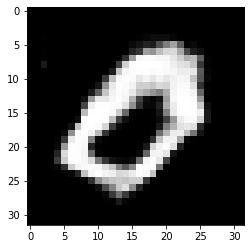

error D >>>  tensor(0.5240, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(1.6419, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  4


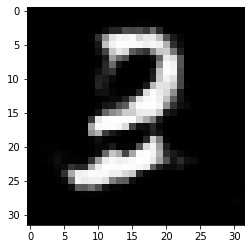

error D >>>  tensor(0.5530, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.0176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  5


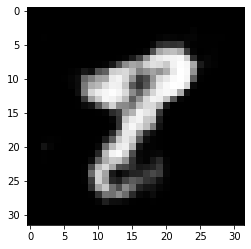

error D >>>  tensor(1.2869, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.3882, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  8


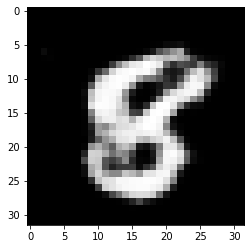

error D >>>  tensor(0.7847, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.6693, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  6


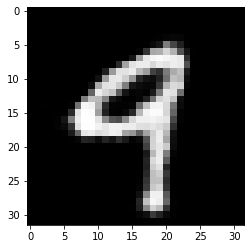

error D >>>  tensor(0.9162, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(1.1533, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  2


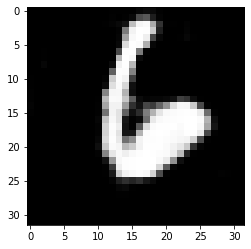

error D >>>  tensor(0.6614, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.4587, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  9


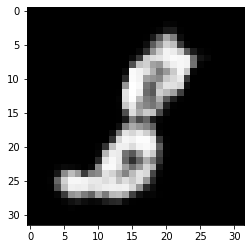

error D >>>  tensor(1.0941, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.7601, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  7


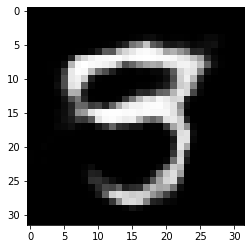

error D >>>  tensor(1.1191, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.9739, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  4


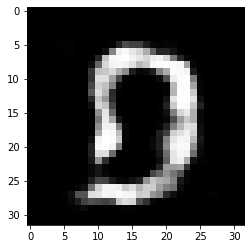

error D >>>  tensor(1.0740, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.0944, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  6


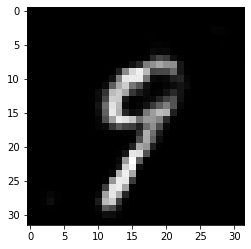

error D >>>  tensor(0.7815, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.4447, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  8


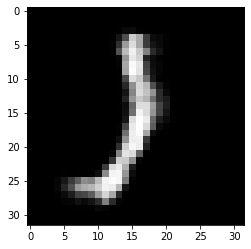

error D >>>  tensor(0.9178, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.2173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  0


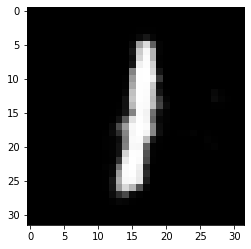

error D >>>  tensor(1.2332, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(0.6843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  8


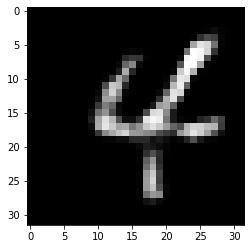

error D >>>  tensor(0.5626, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(0.7080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


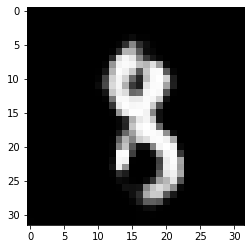

error D >>>  tensor(0.8329, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.4058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  8


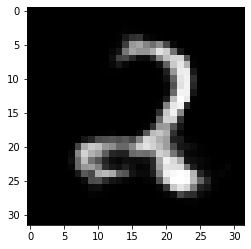

error D >>>  tensor(0.8198, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(1.5732, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  0


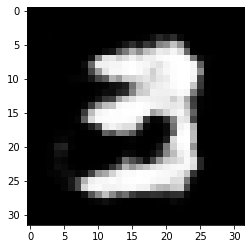

error D >>>  tensor(0.7498, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(1.0875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  7


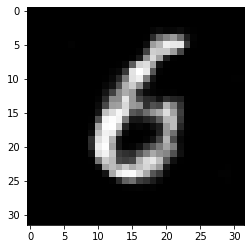

error D >>>  tensor(1.0524, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(0.9304, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  7


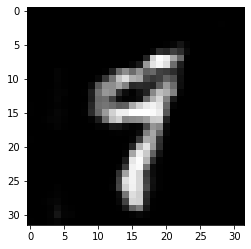

error D >>>  tensor(1.1580, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.9041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  5


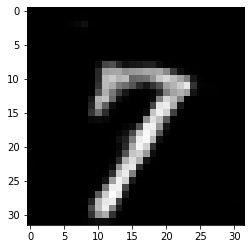

error D >>>  tensor(0.8961, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(1.3689, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  2


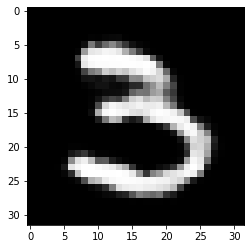

error D >>>  tensor(0.9385, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(1.3798, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  7


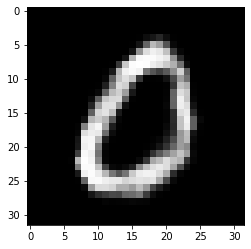

error D >>>  tensor(0.6167, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.6009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  8


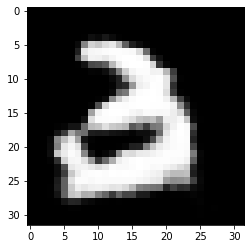

error D >>>  tensor(0.6386, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(1.3761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  0


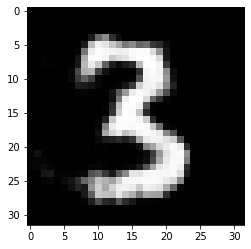

error D >>>  tensor(0.9140, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.7121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  1


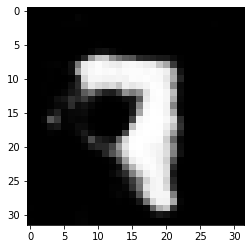

error D >>>  tensor(0.9938, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.5777, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  4


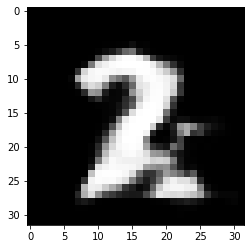

error D >>>  tensor(0.5863, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.6678, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  5


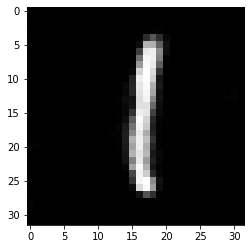

error D >>>  tensor(1.0632, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.9215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  2


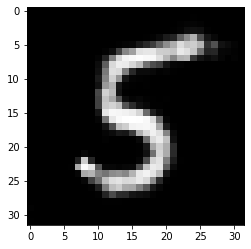

error D >>>  tensor(0.7253, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(1.2968, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  2


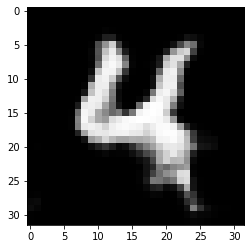

error D >>>  tensor(0.5568, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.2114, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  6


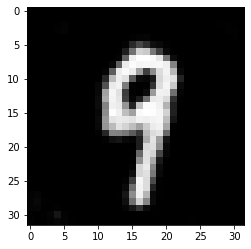

error D >>>  tensor(0.3846, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.4215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  0


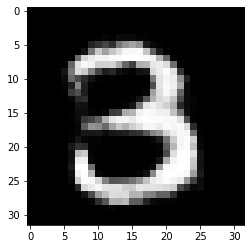

error D >>>  tensor(0.8135, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.5152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


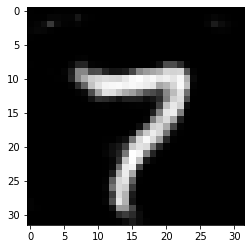

error D >>>  tensor(0.5913, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.3879, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  0


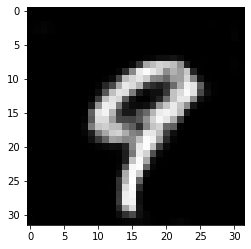

error D >>>  tensor(0.6261, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(1.6837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  4


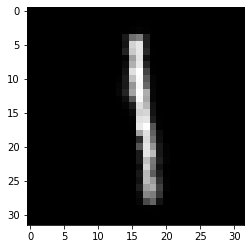

error D >>>  tensor(0.9798, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.0372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  0


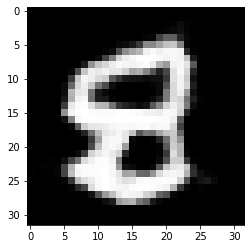

error D >>>  tensor(0.6306, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(1.6290, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  9


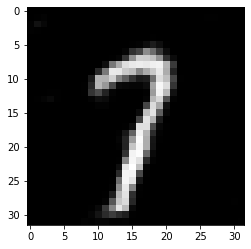

error D >>>  tensor(0.7705, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(1.1998, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  2


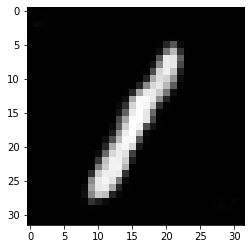

error D >>>  tensor(0.9361, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.5475, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


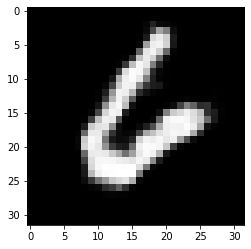

error D >>>  tensor(0.6487, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.7502, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  9


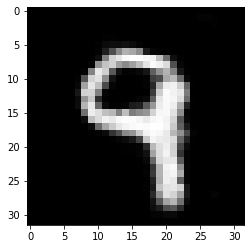

error D >>>  tensor(0.8225, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(0.8627, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  2


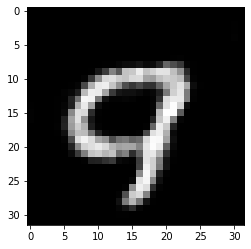

error D >>>  tensor(0.7788, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(1.8570, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  6


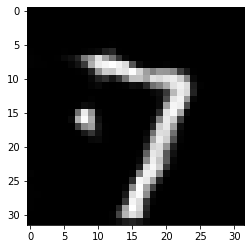

error D >>>  tensor(0.5747, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(1.2828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  4


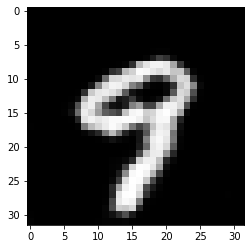

error D >>>  tensor(0.6761, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.5317, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


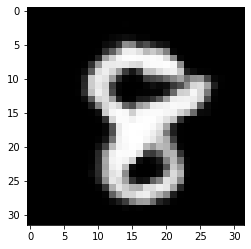

error D >>>  tensor(0.6659, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.9455, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  7


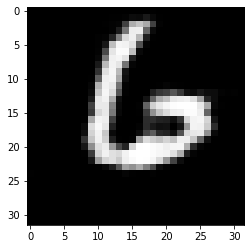

error D >>>  tensor(0.6857, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(1.6111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


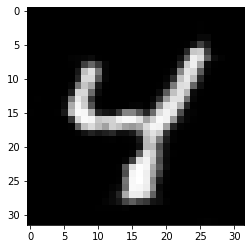

error D >>>  tensor(0.6160, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(1.4699, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  5


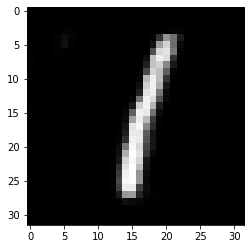

error D >>>  tensor(0.3785, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(1.8678, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  7


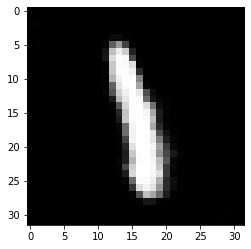

error D >>>  tensor(0.4544, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.4834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  6


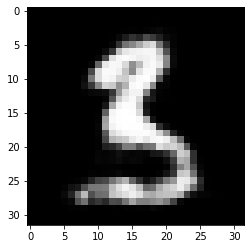

error D >>>  tensor(0.4041, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.5002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


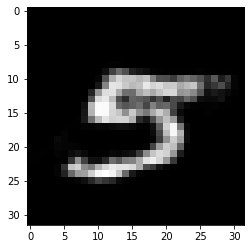

error D >>>  tensor(0.5211, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.6010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  9


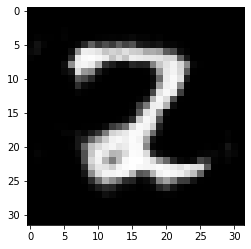

error D >>>  tensor(0.6277, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.4213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  6


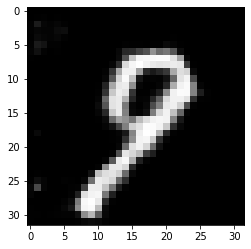

error D >>>  tensor(0.4254, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.8724, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  1


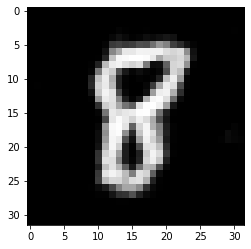

error D >>>  tensor(1.7660, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(1.1385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  1


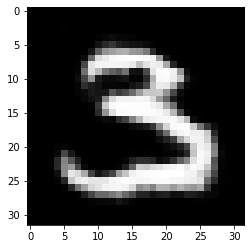

error D >>>  tensor(0.6282, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.0567, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  6


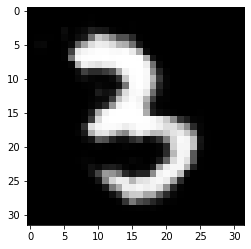

error D >>>  tensor(0.3761, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.0088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  4


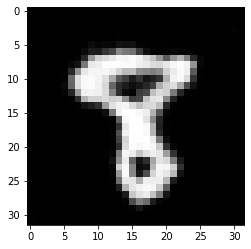

error D >>>  tensor(0.7851, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.3001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  4


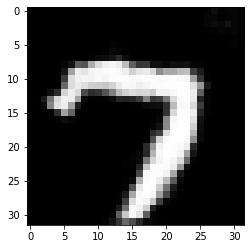

error D >>>  tensor(0.3293, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(1.5607, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  2


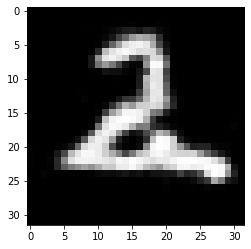

error D >>>  tensor(0.4430, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.4980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  0


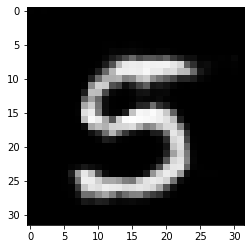

error D >>>  tensor(0.3128, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.0196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  9


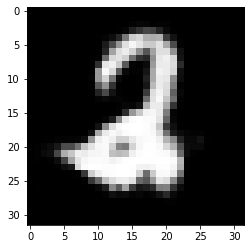

error D >>>  tensor(0.9923, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(0.5771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  9


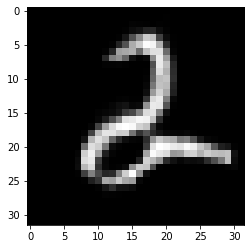

error D >>>  tensor(1.1715, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(1.0384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  5


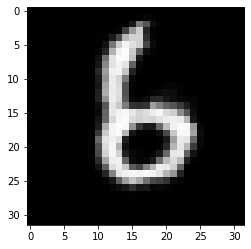

error D >>>  tensor(0.4551, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.3256, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  2


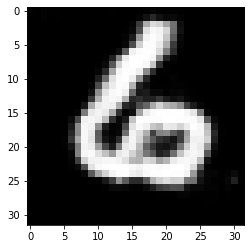

error D >>>  tensor(0.7048, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.6270, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  5


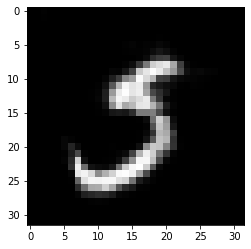

error D >>>  tensor(0.2051, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.9171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  6


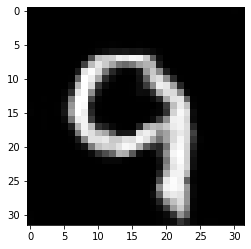

error D >>>  tensor(0.1921, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.7277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  9


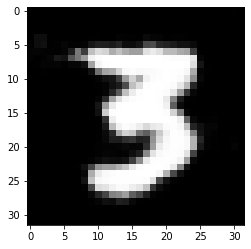

error D >>>  tensor(0.3169, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.7574, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  8


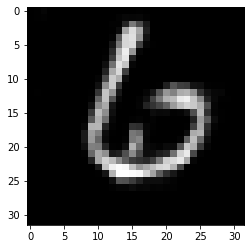

error D >>>  tensor(0.2279, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.7984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  2


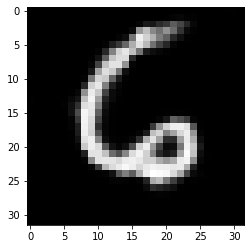

error D >>>  tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.3257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


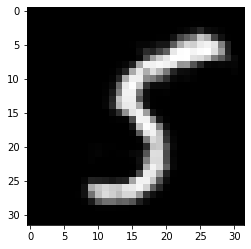

error D >>>  tensor(0.7259, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(1.2033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  7


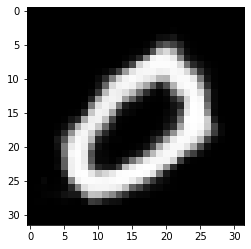

error D >>>  tensor(0.1636, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.5677, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  4


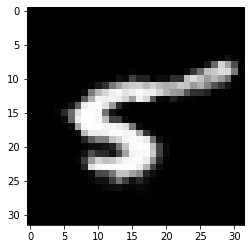

error D >>>  tensor(0.1511, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.4164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  7


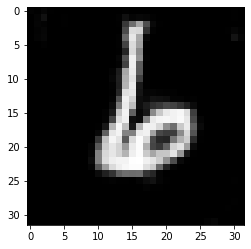

error D >>>  tensor(0.0917, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.5540, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  4


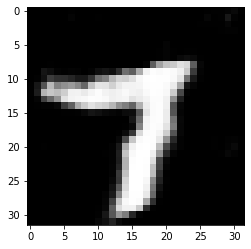

error D >>>  tensor(0.1412, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.3701, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  8


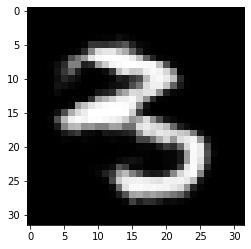

error D >>>  tensor(0.1840, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.3543, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  5


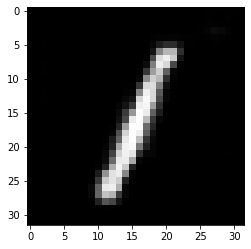

error D >>>  tensor(0.2600, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.2575, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  1


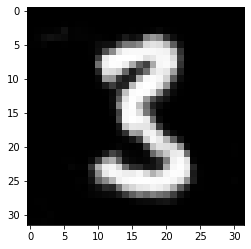

error D >>>  tensor(0.0976, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.4425, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  6


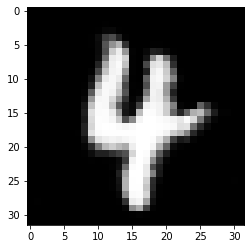

error D >>>  tensor(0.0546, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.8373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
learning rate change!
cls >>>  0


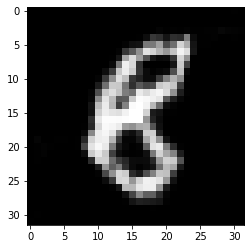

error D >>>  tensor(0.9488, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.0229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  6


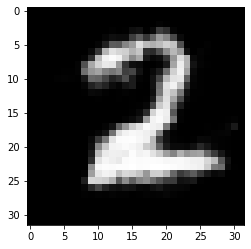

error D >>>  tensor(0.3427, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.6285, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  8


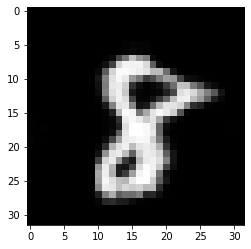

error D >>>  tensor(0.2407, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.5055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  5


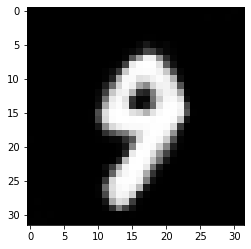

error D >>>  tensor(0.2399, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.7339, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  6


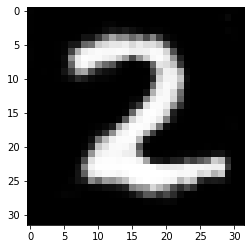

error D >>>  tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.2223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  9


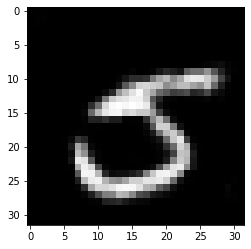

error D >>>  tensor(0.1055, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.9293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  9


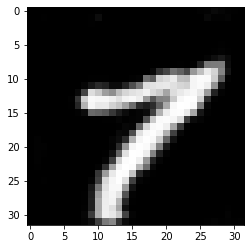

error D >>>  tensor(0.2041, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.0070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  2


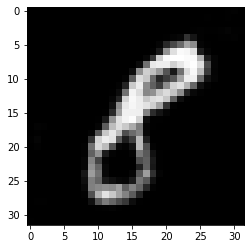

error D >>>  tensor(0.0981, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.1029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  7


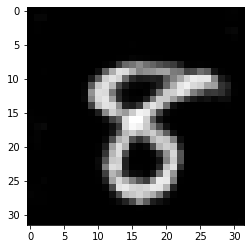

error D >>>  tensor(0.0846, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.4172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  6


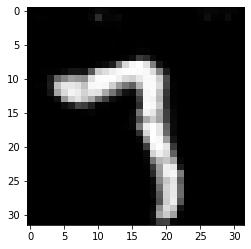

error D >>>  tensor(0.0913, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.0247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  8


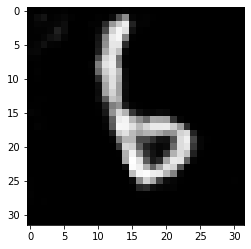

error D >>>  tensor(0.1545, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.3322, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  0


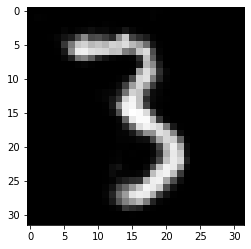

error D >>>  tensor(0.1571, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.2951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  4


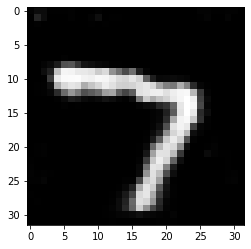

error D >>>  tensor(0.0702, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.2471, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  0


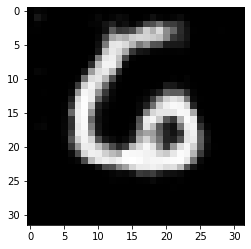

error D >>>  tensor(0.0891, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.8422, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  4


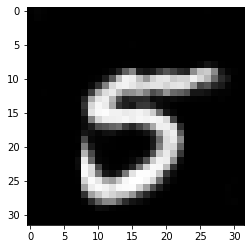

error D >>>  tensor(0.1038, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.8544, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  4


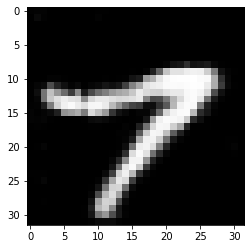

error D >>>  tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.0305, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  6


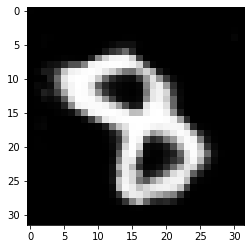

error D >>>  tensor(0.0428, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.8396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  7


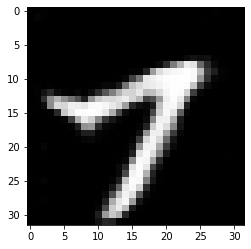

error D >>>  tensor(0.1617, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.1510, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  7


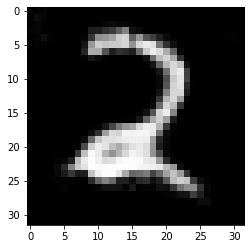

error D >>>  tensor(0.0698, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.6000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  0


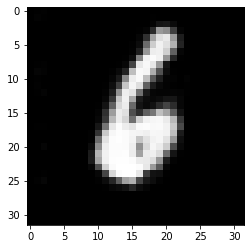

error D >>>  tensor(0.1012, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.7639, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  6


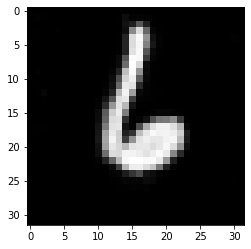

error D >>>  tensor(0.0648, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.6533, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  9


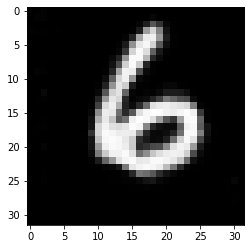

error D >>>  tensor(0.0941, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.0007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  8


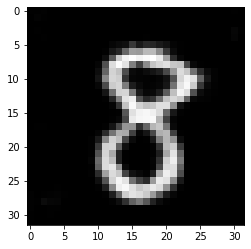

error D >>>  tensor(0.0594, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(2.9187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  1


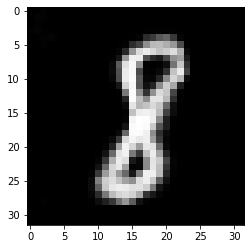

error D >>>  tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.2429, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  5


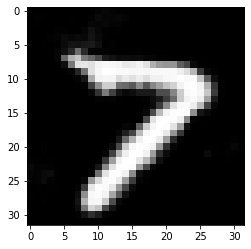

error D >>>  tensor(0.0702, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.6937, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  0


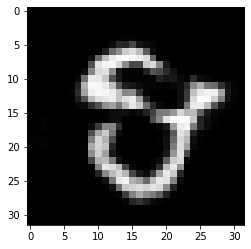

error D >>>  tensor(0.0312, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.5927, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  4


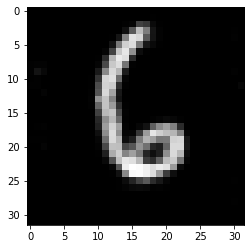

error D >>>  tensor(0.1209, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.2271, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  8


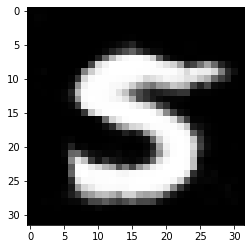

error D >>>  tensor(0.0623, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.2205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


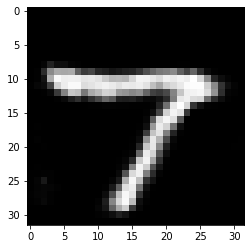

error D >>>  tensor(0.0922, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.8687, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  6


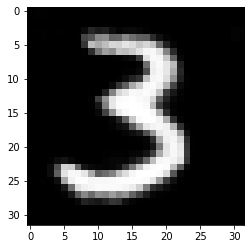

error D >>>  tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.3511, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  1


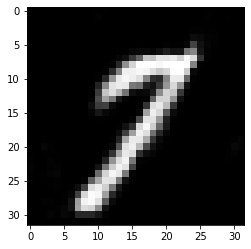

error D >>>  tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.7432, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


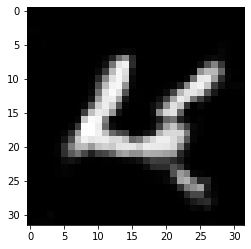

error D >>>  tensor(0.0910, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.0148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  5


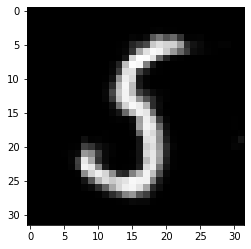

error D >>>  tensor(0.0718, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.3679, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  6


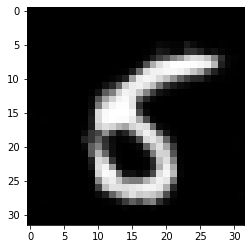

error D >>>  tensor(0.0515, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.0970, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  7


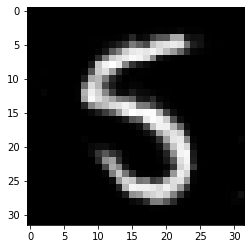

error D >>>  tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.3755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  8


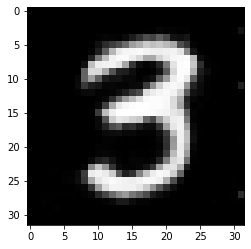

error D >>>  tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.7810, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  1


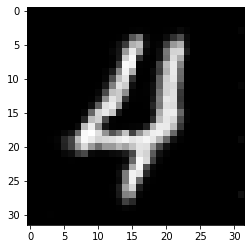

error D >>>  tensor(0.0458, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.6660, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


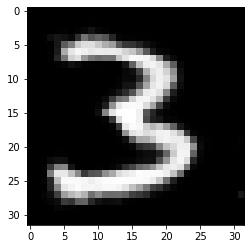

error D >>>  tensor(0.0462, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.3117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  1


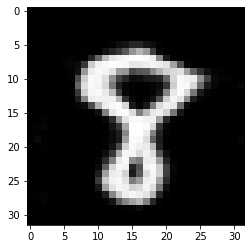

error D >>>  tensor(0.0497, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.6948, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  6


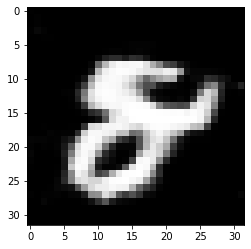

error D >>>  tensor(0.0620, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.8357, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  2


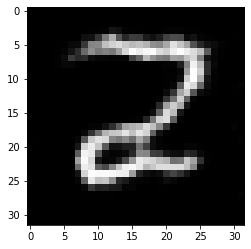

error D >>>  tensor(0.0457, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.8749, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  5


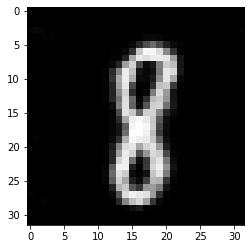

error D >>>  tensor(0.0329, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.7851, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  0


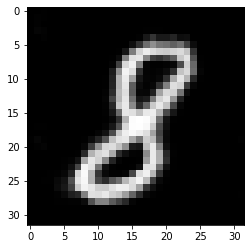

error D >>>  tensor(0.0599, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.5705, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  8


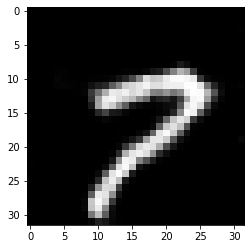

error D >>>  tensor(0.0511, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.0579, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


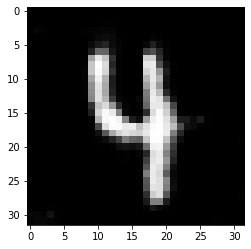

error D >>>  tensor(0.0332, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.2893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  4


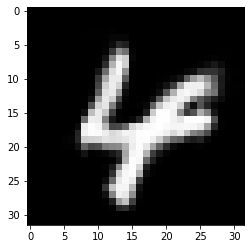

error D >>>  tensor(0.0464, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.4074, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  0


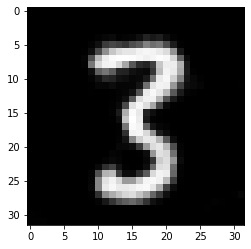

error D >>>  tensor(0.0185, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.3916, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  2


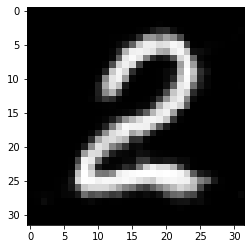

error D >>>  tensor(0.0353, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.1239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  4


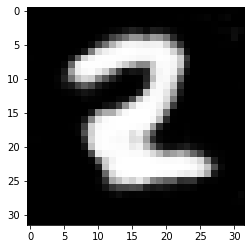

error D >>>  tensor(0.0664, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.9457, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  0


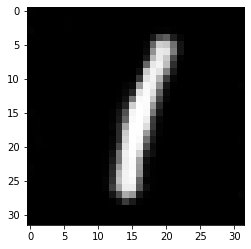

error D >>>  tensor(0.0439, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.6638, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
learning rate change!
cls >>>  2


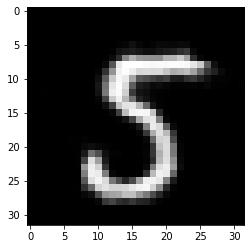

error D >>>  tensor(0.0301, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.7342, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  1


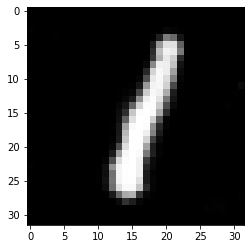

error D >>>  tensor(0.0555, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.8978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


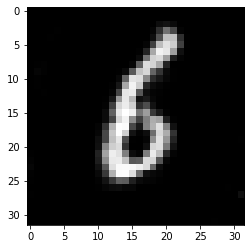

error D >>>  tensor(0.0376, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.6499, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


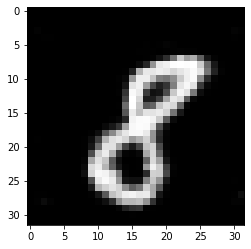

error D >>>  tensor(0.0296, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.4278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


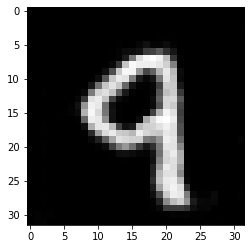

error D >>>  tensor(0.0481, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.3071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  1


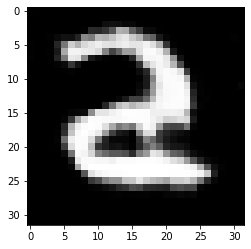

error D >>>  tensor(0.0259, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.2831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  7


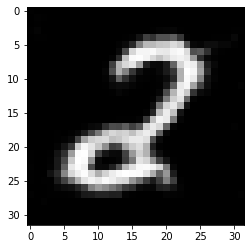

error D >>>  tensor(0.0266, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.3560, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


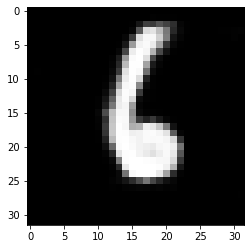

error D >>>  tensor(0.0278, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.4886, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  6


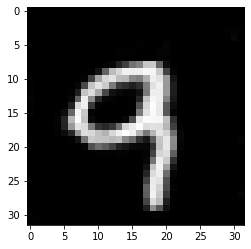

error D >>>  tensor(0.0312, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.9144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  6


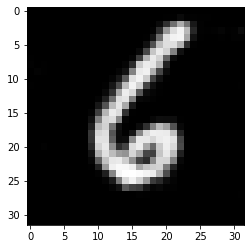

error D >>>  tensor(0.0384, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.3563, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  7


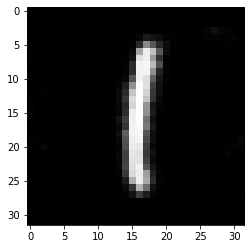

error D >>>  tensor(0.0177, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.1329, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  0


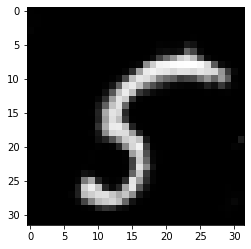

error D >>>  tensor(0.0220, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.2795, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  9


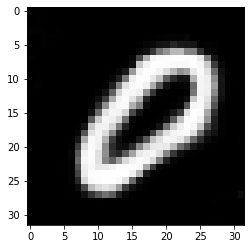

error D >>>  tensor(0.0298, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.9787, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  2


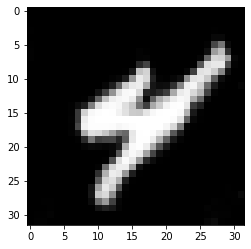

error D >>>  tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.1274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  2


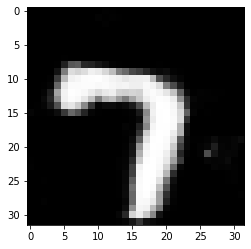

error D >>>  tensor(0.0211, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.1049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  0


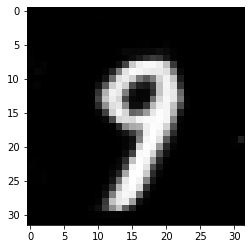

error D >>>  tensor(0.0272, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.7314, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  0


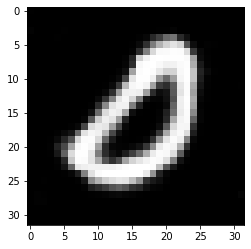

error D >>>  tensor(0.0217, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.0532, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  9


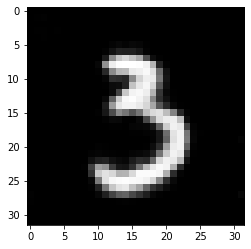

error D >>>  tensor(0.0291, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.8994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  9


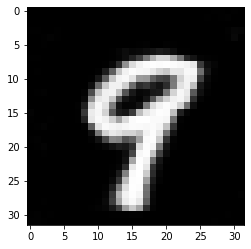

error D >>>  tensor(0.0384, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.9924, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  4


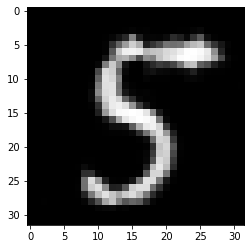

error D >>>  tensor(0.0250, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.3917, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  1


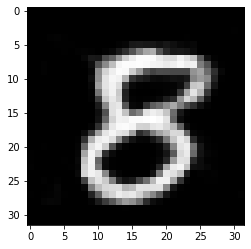

error D >>>  tensor(0.0174, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(3.9329, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  5


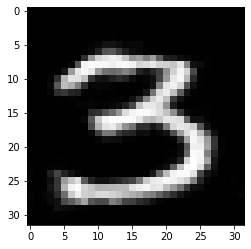

error D >>>  tensor(0.0349, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.5033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  6


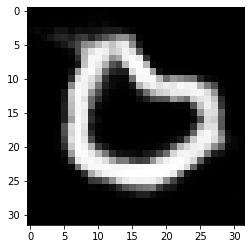

error D >>>  tensor(0.0250, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.7681, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  4


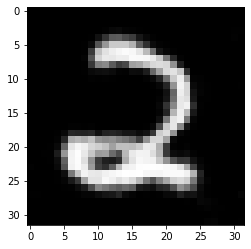

error D >>>  tensor(0.0265, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.1265, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  0


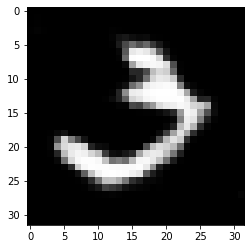

error D >>>  tensor(0.0244, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.4444, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  7


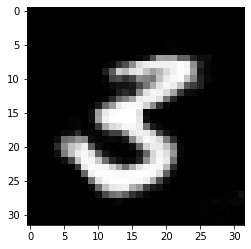

error D >>>  tensor(0.0154, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.1057, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  1


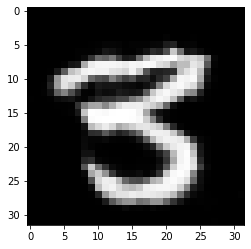

error D >>>  tensor(0.0618, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.9923, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  1


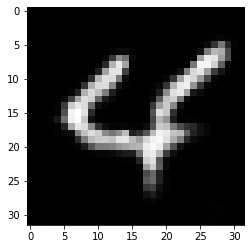

error D >>>  tensor(0.0664, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.0978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  2


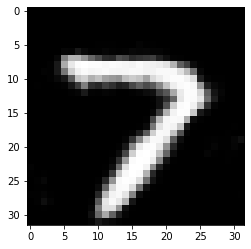

error D >>>  tensor(0.0369, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.0081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


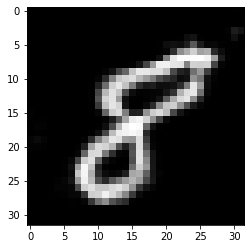

error D >>>  tensor(0.0191, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.8563, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  9


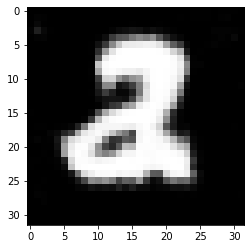

error D >>>  tensor(0.0352, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.2353, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  8


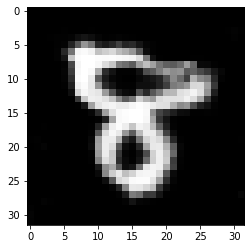

error D >>>  tensor(0.0302, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.3943, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


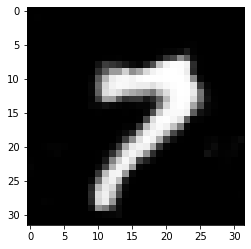

error D >>>  tensor(0.0168, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.0880, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  0


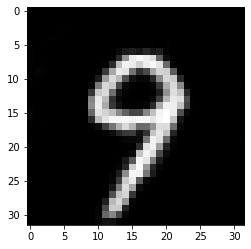

error D >>>  tensor(0.0222, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.1851, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


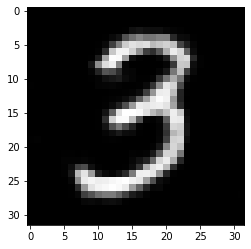

error D >>>  tensor(0.0318, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.0884, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  7


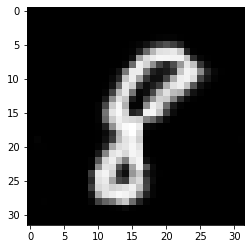

error D >>>  tensor(0.0464, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.2277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  8


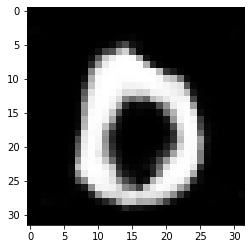

error D >>>  tensor(0.0172, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.7594, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  1


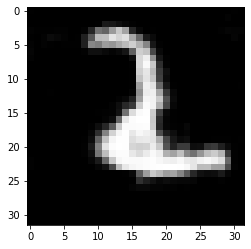

error D >>>  tensor(0.0199, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.2103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  8


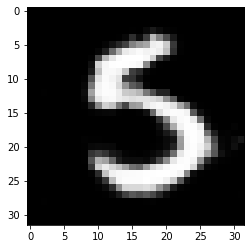

error D >>>  tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.7048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


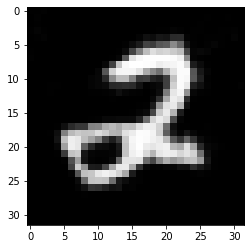

error D >>>  tensor(0.0182, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.8509, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  8


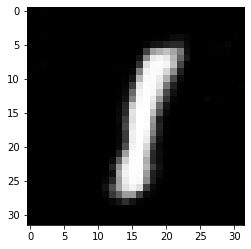

error D >>>  tensor(0.0150, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.1514, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  2


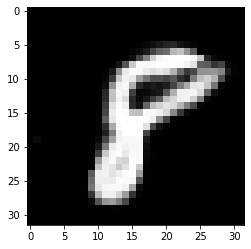

error D >>>  tensor(0.0355, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.5700, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  7


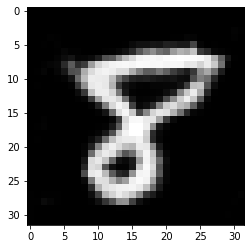

error D >>>  tensor(0.0309, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.3730, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  6


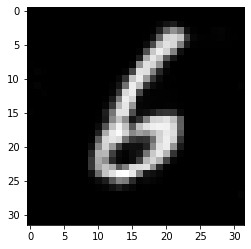

error D >>>  tensor(0.0232, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.7396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  5


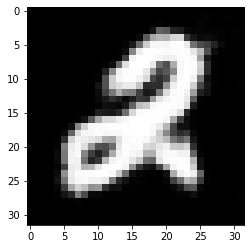

error D >>>  tensor(0.0150, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.7041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  4


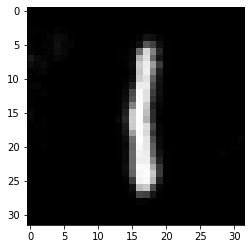

error D >>>  tensor(0.0384, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.4107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  5


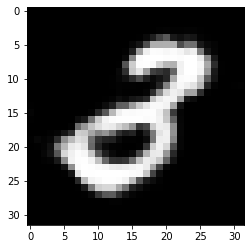

error D >>>  tensor(0.0072, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.0860, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  7


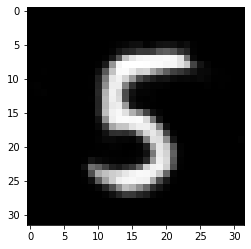

error D >>>  tensor(0.0339, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.1811, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


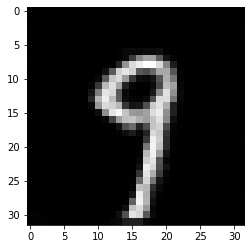

error D >>>  tensor(0.0279, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.1070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
cls >>>  3


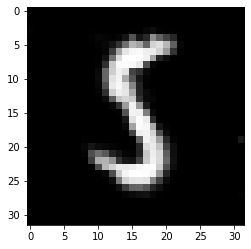

error D >>>  tensor(0.0227, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(4.4216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


In [47]:
# Training Loop
# Lists to keep track of progress
G_losses = []
D_losses = []

# training parameters
num_epochs = 20

# data arameters
ncls=10
noisedim=100

#labels
rlabel = torch.full((batch_size,), real_label).to(device)
flabel = torch.full((batch_size,), fake_label).to(device)
grlabel = torch.full((batch_size,), real_label).to(device) # generator sees its geenerated samples as real

print("Starting Training Loop >>>")
# For each epoch
for epoch in range(num_epochs):
    
    # learning rate decay
    if (epoch+1) == 11:
        optimizerD.param_groups[0]['lr'] /= 10
        optimizerG.param_groups[0]['lr'] /= 10
        print("learning rate change!")

    if (epoch+1) == 16:
        optimizerD.param_groups[0]['lr'] /= 10
        optimizerG.param_groups[0]['lr'] /= 10
        print("learning rate change!")
        
    # For each batch in the dataloader
    for i,data in enumerate(dataloader):
        
        yf = torch.zeros(batch_size,ncls,1,1).to(device)
        yfg = torch.zeros(batch_size,ncls,1,1).to(device)
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        if data[0].shape[0]<batch_size:
            continue
        netD.zero_grad()
        # train with all real batch
        # encode numerical label into one hot vector
        # one hot vector for label
        y = torch.zeros(batch_size,ncls,1,1).to(device)
        for x,l in enumerate(data[1]):
            y[x,l.item(),:,:]=1.0
        # expnad y dimentions
        y=y.expand(-1,-1,32,32)
        # feed (batch_size,ncls,32,32) tensor to pre-discriminator network
        input_d_part1 = predisc1(y)
        # feed (batch_size,1,32,32) (image) tensor to pre-discriminator network
        input_d_part2 = predisc2(data[0].to(device))
        # concat part1 ,part2
        merge1=torch.cat((input_d_part1,input_d_part2),1)
        # now merge is tensor with shape (batch_size,128,16,16)
        # next step >> forward merge to Discriminator
        netout1=netD(merge1)
        # compute loss
        errD_real=criterion(netout1,rlabel)
        # Calculate gradients for Discriminator in backward pass
        errD_real.backward(retain_graph=True)
        
        ## Train with all-fake batch
        noise = torch.randn(batch_size,noisedim , 1, 1).to(device)
        # feed noise tensor >>> (64,100,1,1) to pre-generator network
        gen_part1 = pregen1(noise)
        # now gen_part1 is tensor (batch_size,256,4,4)
        # generate random fake label
        for b in range(batch_size):
            yf[b,torch.randint(low=0,high=10,size=(1,)).item(),:,:]=1.0
        gen_part2=pregen2(yf)
        # now gen_part2 is tensor (batch_size,256,4,4)
        # concat the two tensors
        merge2=torch.cat((gen_part1,gen_part2),1)
        # forward merge2 tensor (batch_size,512,4,4)
        fake_sample = netG(merge2)
        # pass fake_sample (batc_size,1,32,32) to disriminator
        gen_input_d_part2 = predisc2(fake_sample)
        # gen_input_d_part2 >>> (batc_size,64,16,16)
        yf=yf.expand(-1,-1,32,32)
        gen_input_d_part1 = predisc1(yf)
        merge3=torch.cat((gen_input_d_part1,gen_input_d_part2),1)
        netout2 = netD(merge3)
        # compute loss
        errD_fake = criterion(netout2,flabel)
        # Calculate gradients for Discriminator in backward pass
        errD_fake.backward(retain_graph=True)
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        
        netG.zero_grad()
        noise = torch.randn(batch_size,noisedim , 1, 1).to(device)
        # feed noise tensor >>> (64,100,1,1) to pre-generator network
        gen_part1 = pregen1(noise)
        # now gen_part1 is tensor (batch_size,256,4,4)
        # generate random fake label
        for b in range(batch_size):
            cls = torch.randint(low=0,high=10,size=(1,)).item()
            yfg[b,cls,:,:]=1.0
        yftod = yfg
        yftod = yftod.expand(-1,-1,32,32)
        gen_input_d_part1 = predisc1(yftod)
        gen_part2 = pregen2(yfg)
        # now gen_part2 is tensor (batch_size,256,4,4)
        # concat the two tensors
        merge2=torch.cat((gen_part1,gen_part2),1)
        # forward merge2 tensor (batch_size,512,4,4)
        fake_sample = netG(merge2)
        # pass fake_sample (batc_size,1,32,32) to disriminator
        gen_input_d_part2 = predisc2(fake_sample)
        # gen_input_d_part2 >>> (batc_size,64,16,16)
        merge3=torch.cat((gen_input_d_part1,gen_input_d_part2),1)
        netout2 = netD(merge3)
        errG = criterion(netout2,grlabel)
        errG.backward(retain_graph=True)
        optimizerG.step()
        
        # log errors
        if i%100==0:
            print("error D >>> ",errD)
            print("error G >>> ",errG)

In [71]:
noise = torch.randn(1,noisedim , 1, 1).cuda()
# feed noise tensor >>> (64,100,1,1) to pre-generator network
gen_part1 = pregen1(noise)
# now gen_part1 is tensor (batch_size,256,4,4)
# generate random fake label
yf = torch.zeros(1,ncls,1,1).cuda()
yf[:,9,:,:]=1.0 # supposed to add wanted class to be generated
gen_part2=pregen2(yf)
# now gen_part2 is tensor (batch_size,256,4,4)
# concat the two tensors
merge2=torch.cat((gen_part1,gen_part2),1)
# forward merge2 tensor (batch_size,512,4,4)
fake_sample = netG(merge2)

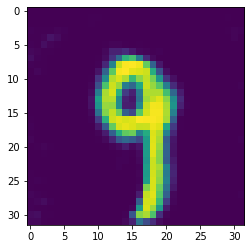

In [72]:
fake=fake_sample.squeeze().cpu().detach().numpy()
fake=fake.squeeze()
plt.imshow(fake)